In [1]:
import numpy as np
import umap
from sklearn.datasets import load_iris, load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
%matplotlib inline
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

pd.options.mode.use_inf_as_na = True

n_test_samples = 10000

open C:\Users\noumi\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\llvmlite\binding\llvmlite.dll


# UMAP embeddings from train + test data

In [2]:
meta = pd.read_feather('../input/meta_exp41.f') # features to use
meta = meta[~meta.distmod.isnull()] # use extragalactic data only
meta.shape

(3107903, 188)

In [3]:
meta_train = meta[~meta.target.isnull()]
meta_train['target'] = 'class_' + meta_train['target'].astype(np.int32).astype(str)

meta_test = meta[meta.target.isnull()].sample(n_test_samples)
meta_test['target'] = 'test data'

meta = pd.concat([meta_train, meta_test]).reset_index(drop=True)
print('Using {} training samples + {} test samples.'.format(len(meta_train), len(meta_test)))

target = meta['target']
object_ids = meta['object_id']
meta.drop(['object_id','target'],axis=1,inplace=True)

C:\Users\noumi\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Using 5523 training samples + 10000 test samples.


In [4]:
meta.head()

,hostgal_photoz_err,distmod,mwebv,mean(flux)_ch0,mean(flux)_ch1,mean(flux)_ch2,mean(flux)_ch3,mean(flux)_ch4,mean(flux)_ch5,max(flux)_ch0,...,sn_salt2_t0_err,sn_salt2_x0_err,sn_salt2_x1_err,sn_salt2_c_err,luminosity_est_diff_ch0,luminosity_est_diff_ch1,luminosity_est_diff_ch2,luminosity_est_diff_ch3,luminosity_est_diff_ch4,luminosity_est_diff_ch5
0,0.2552,45.4063,0.007,-2.720398,-1.019804,-0.794238,-0.986966,-0.900262,-1.794175,14.509829,...,1.394972,5.811610e-07,2.280982,0.061180,211.428790,150.698699,148.907139,171.520862,159.879998,209.527724
1,0.0157,40.2561,0.021,-0.048080,0.141057,2.400870,3.236164,4.308728,4.539396,5.942166,...,0.513719,1.039478e-06,0.337784,0.047594,12.716791,12.289472,32.249454,52.759910,63.564561,89.903437
2,1.1523,40.7951,0.007,1.797523,5.717394,9.711532,14.412924,13.134436,10.746138,18.014029,...,NaN,NaN,NaN,NaN,48.764548,436.357418,496.715563,463.831638,443.631155,338.108118
3,0.0176,40.4166,0.024,0.660948,4.634637,10.243968,11.086555,9.906102,6.896742,5.330927,...,0.405386,1.092627e-06,0.113983,0.010265,16.383640,53.721356,146.825743,192.541554,216.201443,162.029806
4,0.0304,39.7279,0.019,14.888847,46.565932,41.108625,33.614120,25.112238,21.894274,276.159576,...,0.073249,8.796682e-06,0.090596,0.003304,114.799687,588.662887,524.165203,407.783834,301.030369,270.329807


## Preprocessing Data (filling NA, Inf & normalizing)

In [5]:
for c in tqdm(meta.columns):
    meta[c].fillna(meta[c].mean(), inplace=True)

100%|██████████████████████████████████████████████████████████████████████████████| 186/186 [00:00<00:00, 2869.26it/s]


In [6]:
scaler = StandardScaler()
meta = scaler.fit_transform(meta)

In [29]:
import matplotlib as mpl

def plot(embedding, target, n_neighbors, min_dist, alpha=0.6, mask_classes=None, xrange=None, yrange=None, dot_size=4):  
    if mask_classes:
        tgt = ['class_{}'.format(c) for c in mask_classes] + ['test data']
        mask = [t in tgt for t in target]
        embedding = embedding[mask]
        target = target[mask].reset_index(drop=True)

    classes = target.unique()
    lbl = {c:i for i,c in enumerate(classes)}
    labels = np.array([lbl[target[i]] for i in range(len(target))])

    cmap = mpl.colors.ListedColormap(['red', 'yellow', 'blue', 'orange', 'magenta', 'green', 'lightgreen', 'maroon', 'cyan', 'lightgray'])
   
    plt.figure(figsize=(30,20))
 
    plt.scatter(embedding[:, 0], embedding[:, 1], s=dot_size, c=labels, cmap=cmap, alpha=alpha)
    #plt.gca().set_aspect('equal', 'datalim')
    boundaries = np.arange(len(classes)+1)-0.5
    cbar = plt.colorbar(boundaries=boundaries)
    cbar.set_ticks(np.arange(len(classes)+1))
    cbar.set_ticklabels(classes)
        
    if xrange:
        plt.xlim(xrange)
    if yrange:
        plt.ylim(yrange)
       
    title = 'UMAP projection of the PLaSTiCC(n_neighbors:{},min_dist:{})'.format(n_neighbors,min_dist)
    if mask_classes is not None:
        title += ', Show only class {} + test'.format(mask_classes)
    plt.title(title, fontsize=24)

## Execute UMAP

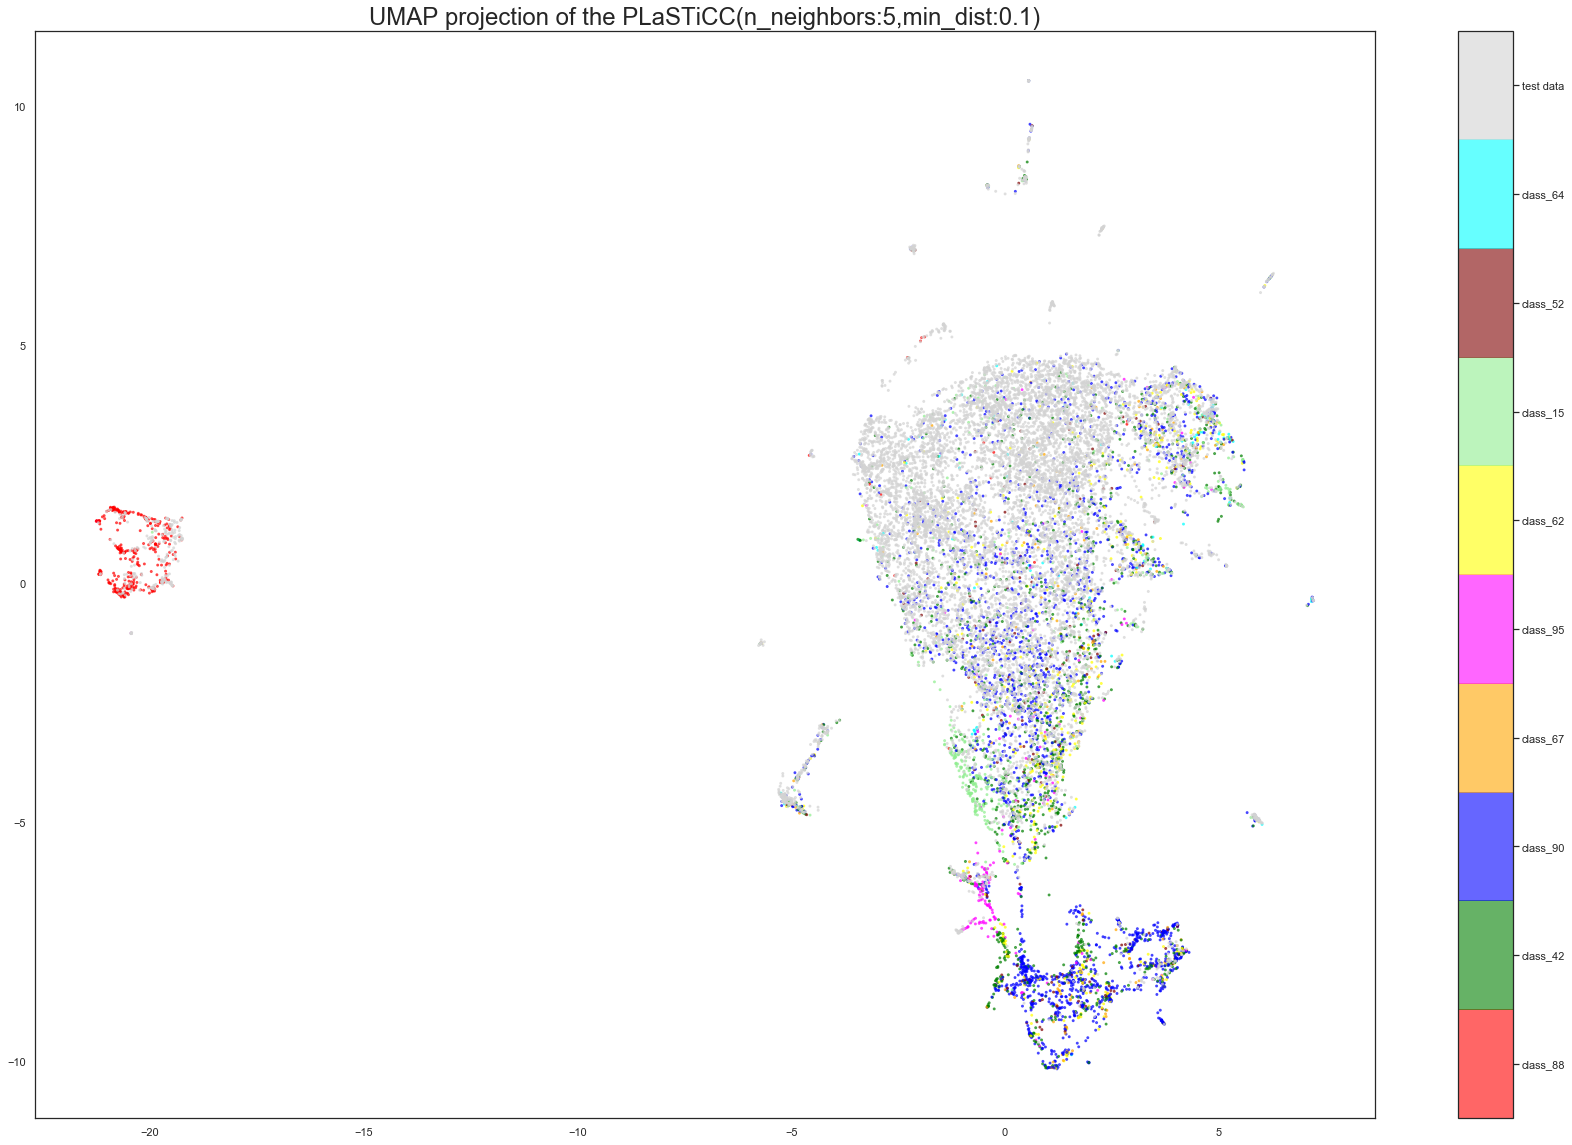

In [14]:
n_neighbors=5
min_dist=0.1
reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist)
embedding = reducer.fit_transform(meta)
plot(embedding, target, n_neighbors, min_dist)

Some interesting points I've found:
- **Train & test data are apparently different** - majority of training data (bottom right) don't belong to main cluster of test data (top right). It may explain why pseudo-labelling works (PL works as a data augmentation in the top right area)
- **There are few small clusters which contains small or no training data** - class 99 candidate? A mere error of UMAP itself?
- **There is a small drift between class88 vs class88-like test data (left)** - Are these test data class88? Or class99 which is similar to 88? (e.g. active galactic nuclei) 

Let's focus on particular class vs test data.

## Class90 (SNIa) vs Test 

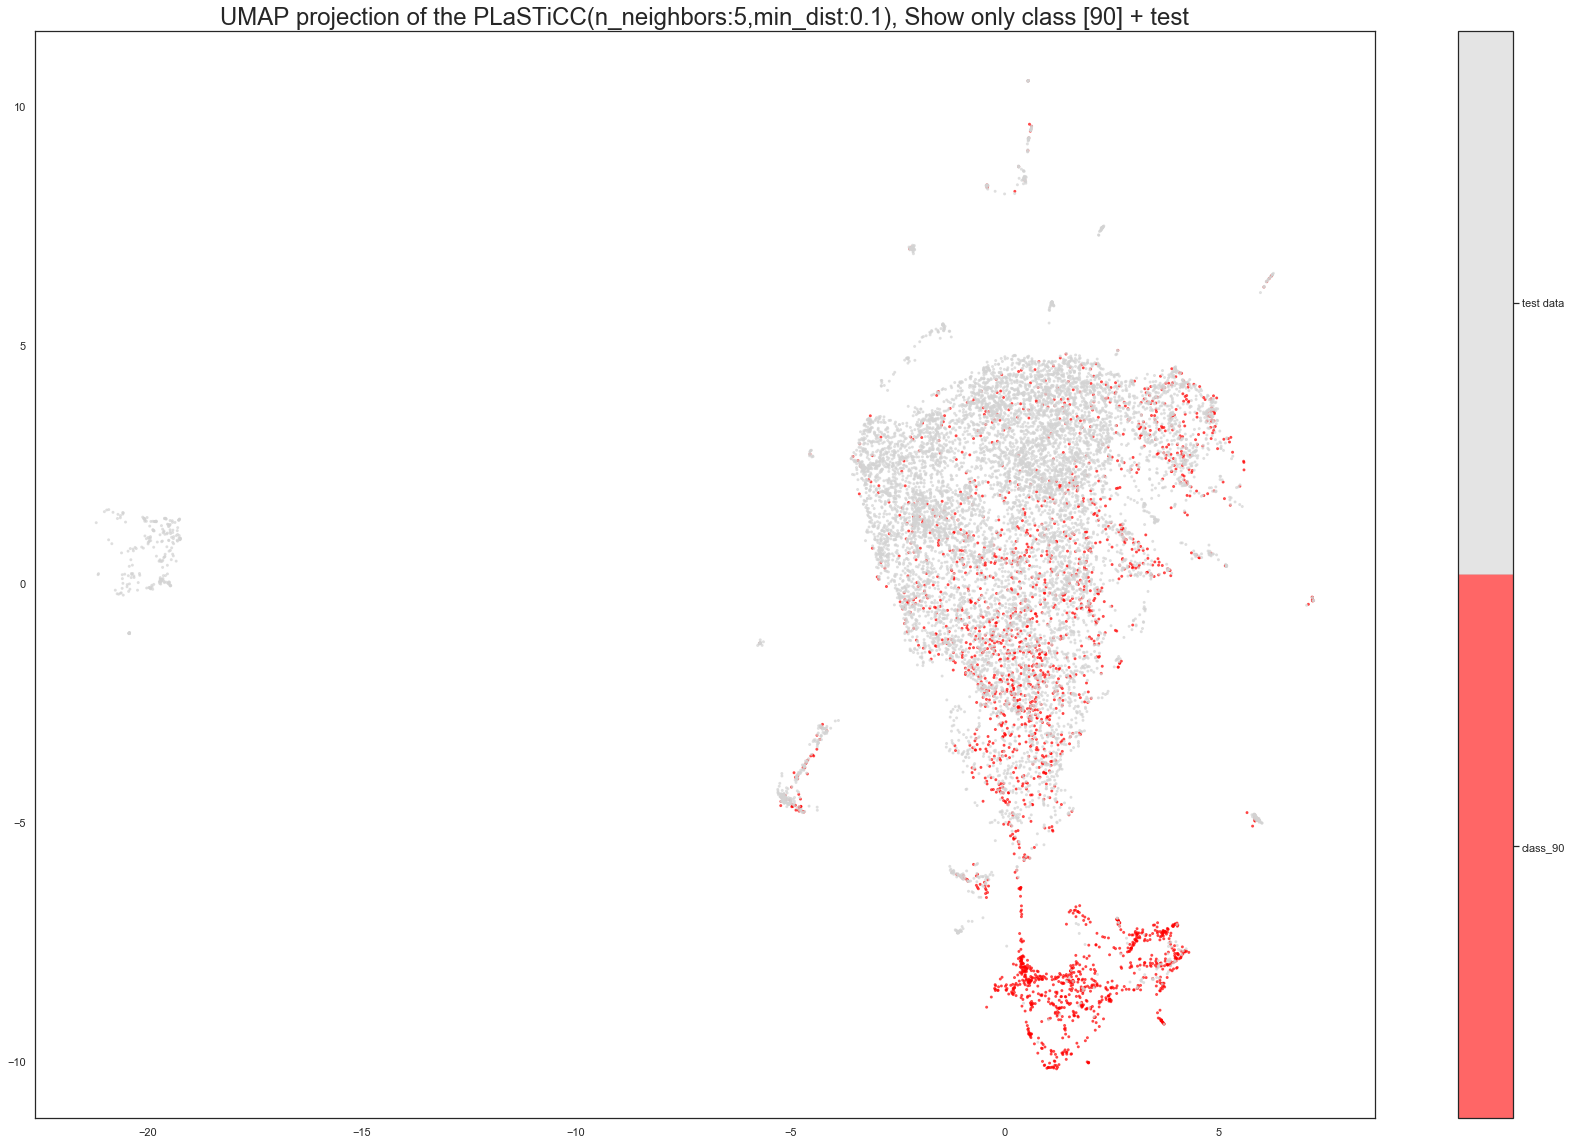

In [30]:
plot(embedding, target, n_neighbors, min_dist, mask_classes=[90])

## Class88 (Strong Gravitational Lens) vs Test 

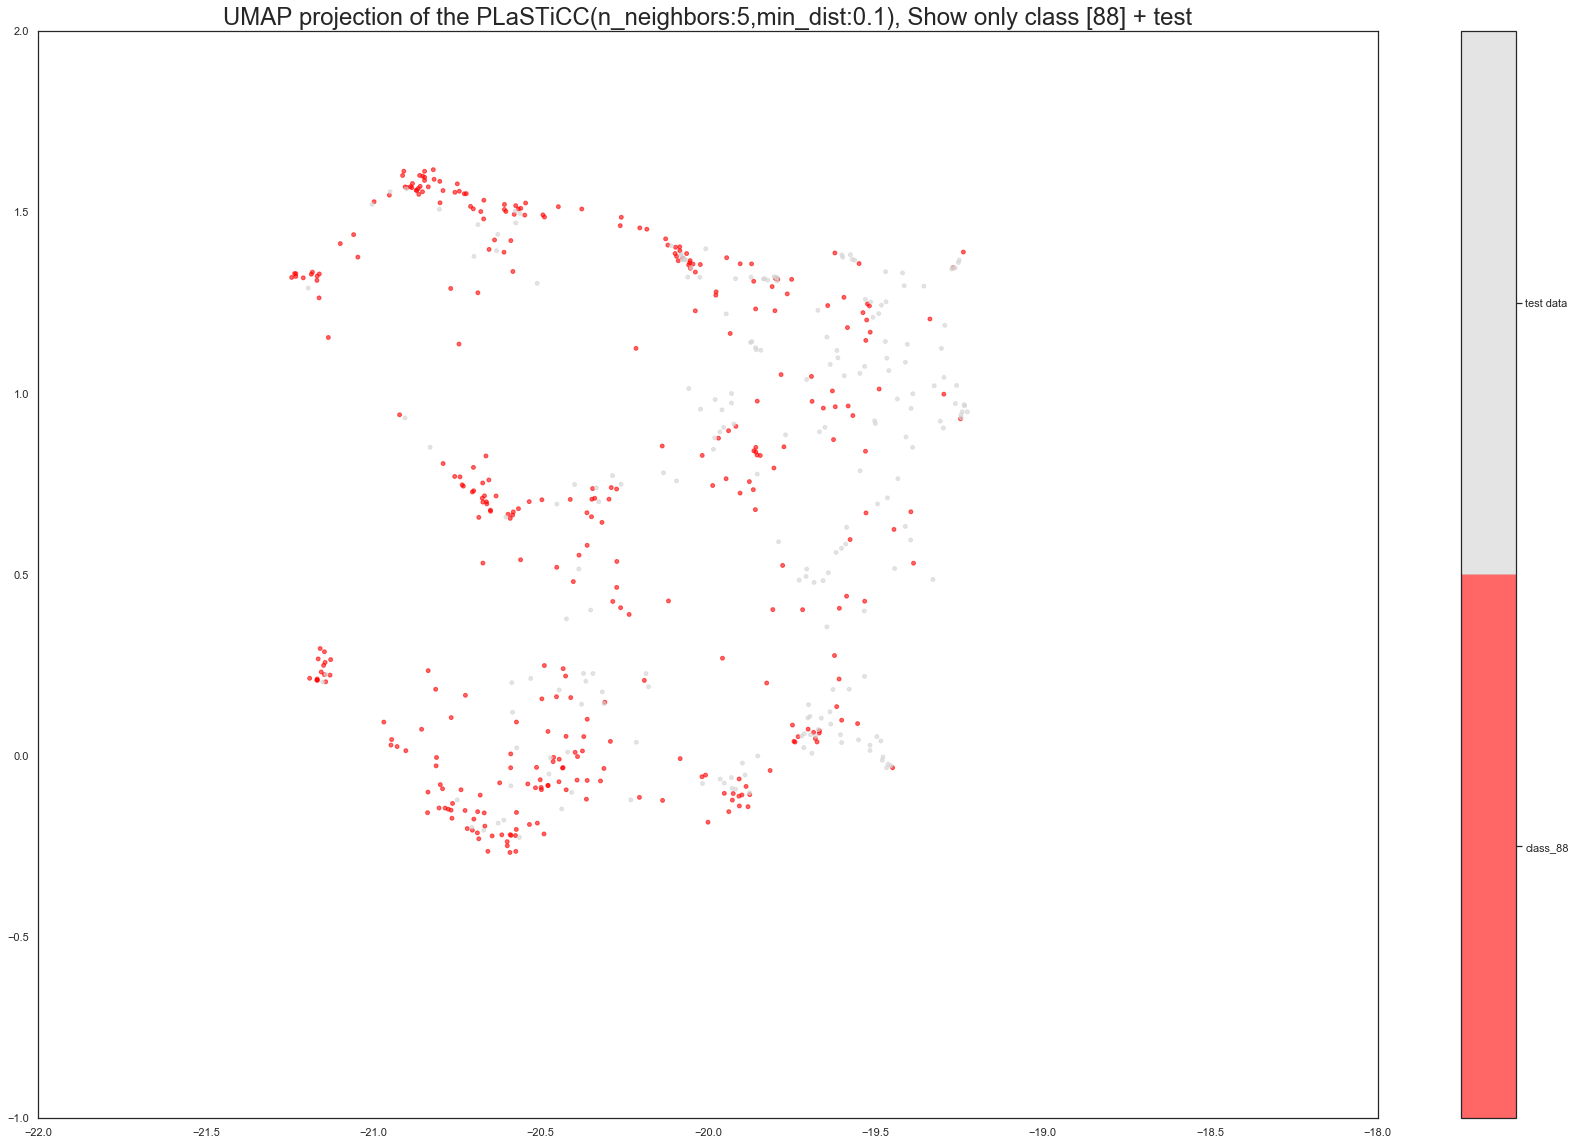

In [27]:
plot(embedding, target, n_neighbors, min_dist, mask_classes=[88], xrange=(-22,-18), yrange=(-1,2), dot_size=15)

## Class52+62 (SNIb/c? hard classes) vs Test 

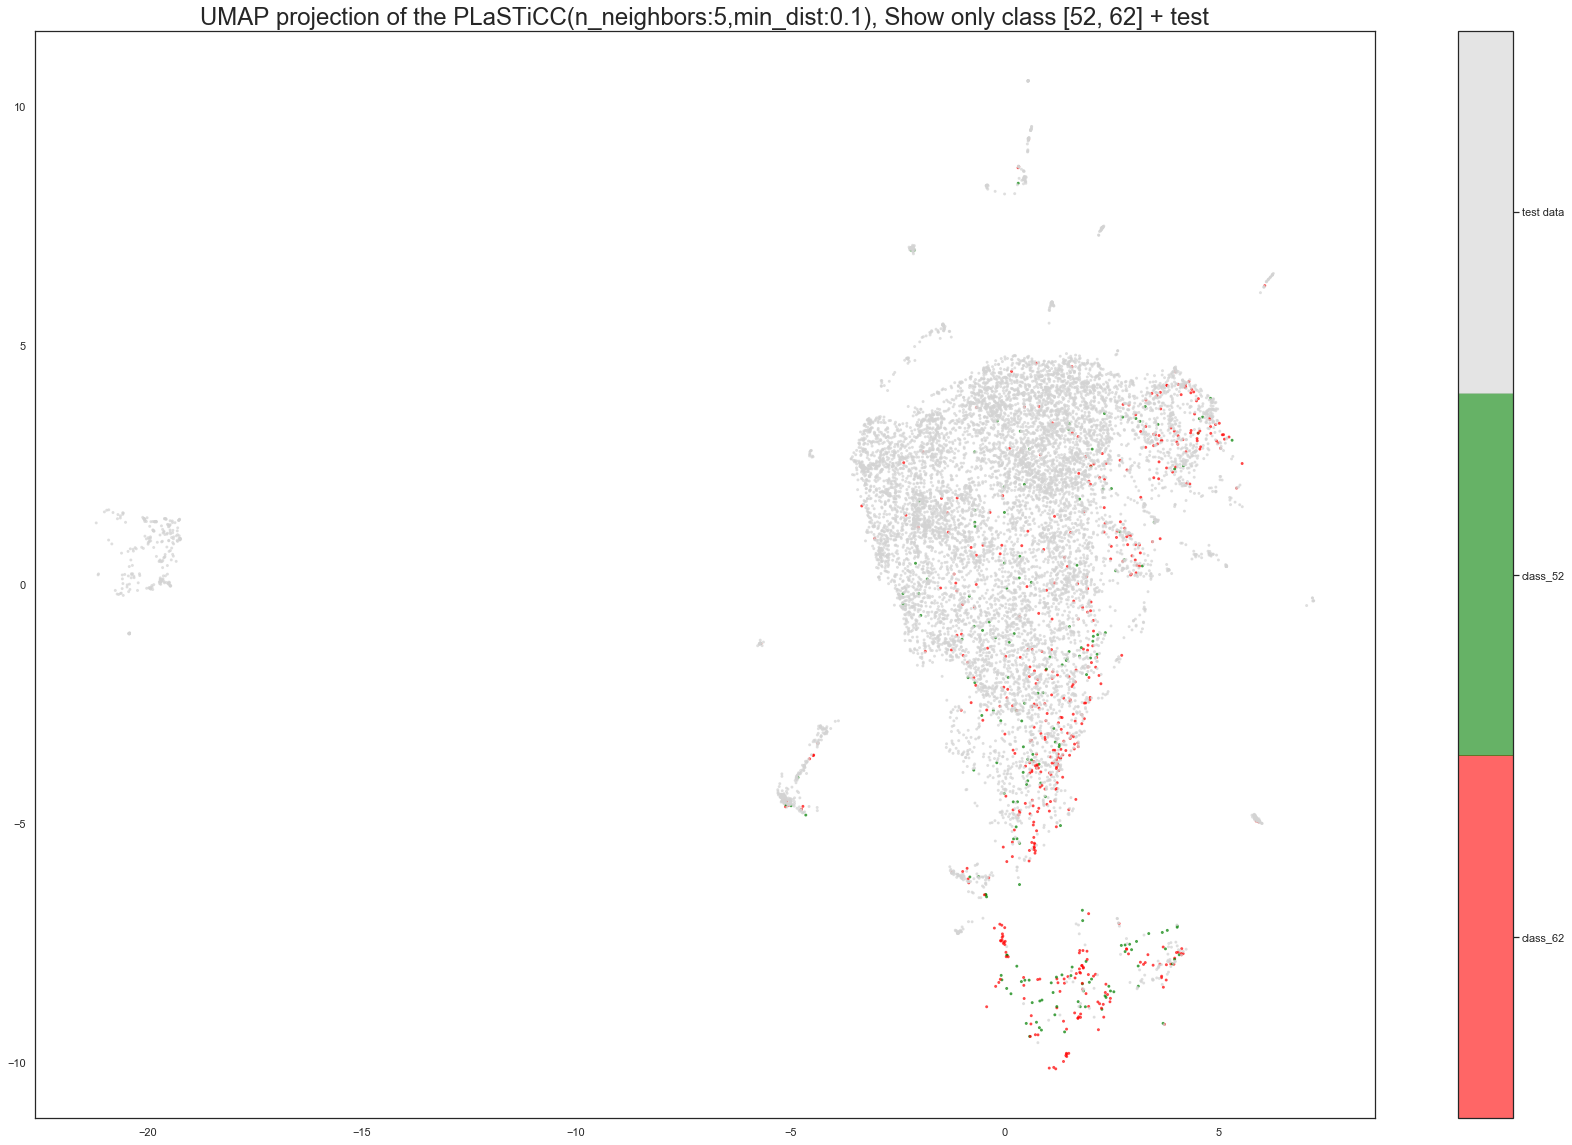

In [31]:
plot(embedding, target, n_neighbors, min_dist, mask_classes=[52,62])

## UMAP with different hyperparameters

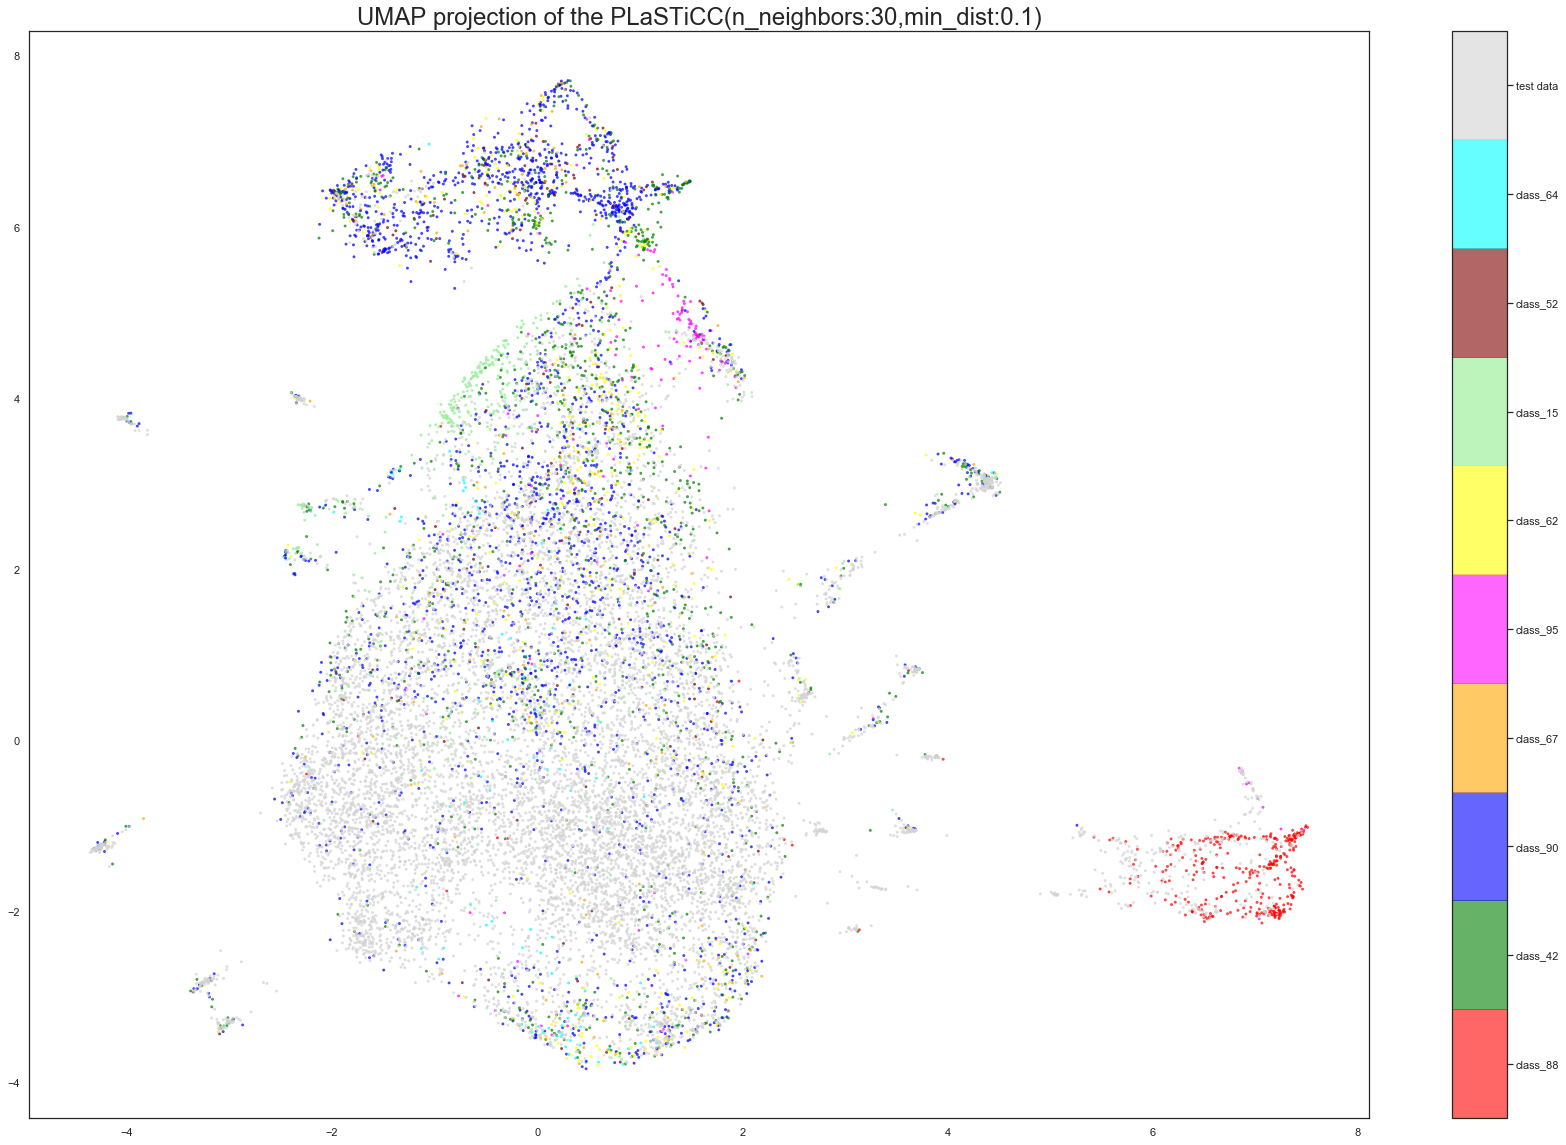

In [12]:
n_neighbors=30
min_dist=0.1
reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist)
embedding = reducer.fit_transform(meta)
plot(embedding, target, n_neighbors, min_dist)

C:\Users\noumi\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 5 separate connected components using meta-embedding (experimental)
  n_components
C:\Users\noumi\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\manifold\spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


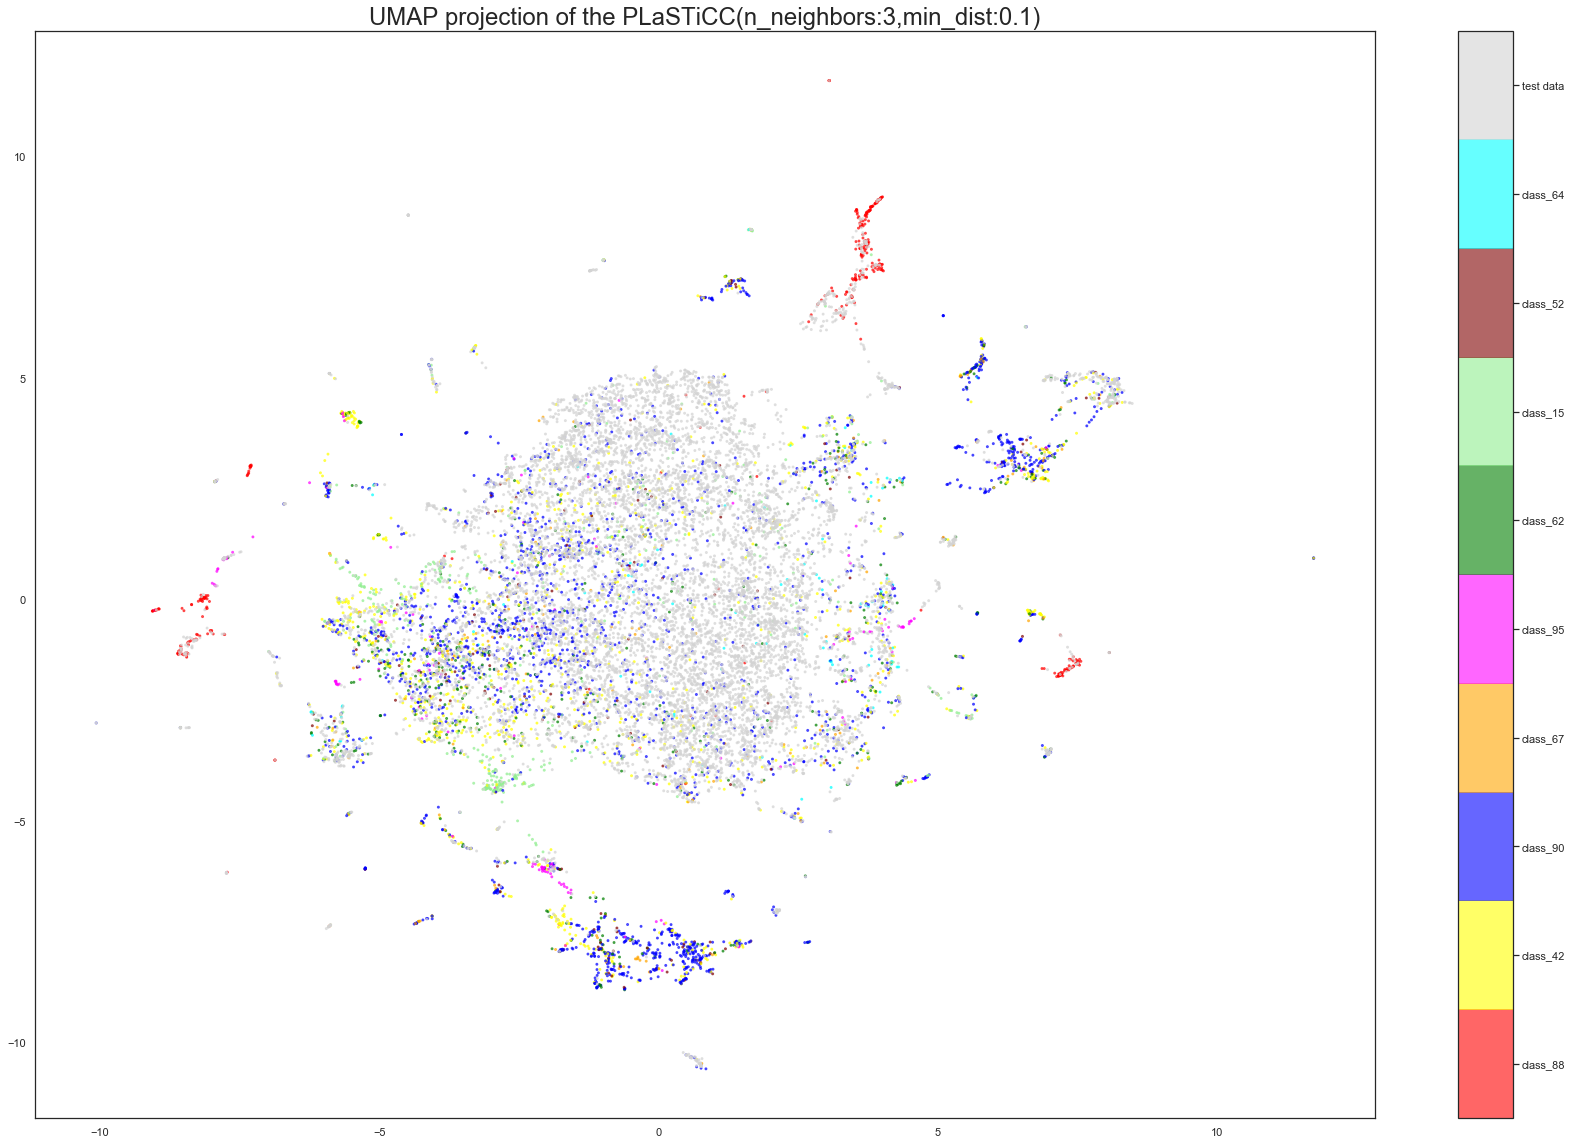

In [32]:
n_neighbors=3
min_dist=0.1
reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist)
embedding = reducer.fit_transform(meta)
plot(embedding, target, n_neighbors, min_dist)